---
# 스포츠센터 회원 이탈 예측 프로젝트
---

# 프로젝트 개요
- 기간: 2023.12.06 ~ 2024.12.17
- 인원: 1명
- 목적: 줄어드는 신규 회원 + 증가하는 탈퇴 회원 추세를 확인하여 회원 유지를 위한 전략 필요

## 라이브러리 호출 및 커스텀 설정

In [528]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


# 폰트 설정
plt.rcParams['font.family'] = 'paybooc'
plt.rcParams['axes.unicode_minus'] = False

# 파일 디렉토리 설정
file_dir = '../data'

# 경고 비표시
warnings.filterwarnings('ignore')

## 활용 데이터
- campaign : 진행한 캠페인 ID, 내용
- class : 스포츠센터 시간에 따른 클래스 구분
- uselog_df : 회원ID별 이용한 일자
- customer : 회원 이름, 성별, 클래스, 등록일, 탈퇴일, 탈퇴여부
    (등록일 기간 : 2015~2019)

In [425]:
campaign_df = pd.read_csv(os.path.join(file_dir,'campaign_master.csv'))
class_df = pd.read_csv(os.path.join(file_dir,'class_master.csv'))
customer_df = pd.read_csv(os.path.join(file_dir,'customer_master.csv'))
uselog_df = pd.read_csv(os.path.join(file_dir,'use_log.csv'))

In [426]:
display(campaign_df.head())
campaign_df = campaign_df.rename(columns={'campaign_id':'캠페인ID','campaign_name':'혜택'})
display(campaign_df.head())

,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


,캠페인ID,혜택
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


In [427]:
display(class_df.head())
class_df = class_df.rename(columns={'class':'클래스ID','class_name':'클래스분류','price':'가격'})
display(class_df.head())

,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


,클래스ID,클래스분류,가격
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [428]:
display(customer_df.head())
customer_df = customer_df.rename(columns={
    'customer_id':'회원ID',
    'name':'회원명',
    'class':'클래스ID',
    'gender':'성별',
    'start_date':'회원등록일',
    'end_date':'회원탈퇴일',
    'campaign_id':'캠페인ID',
    'is_deleted':'탈퇴여부'})       #탈퇴 회원은 1, 유지 회원은 0으로 표기
display(customer_df.head())

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


,회원ID,회원명,클래스ID,성별,회원등록일,회원탈퇴일,캠페인ID,탈퇴여부
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [429]:
display(uselog_df.head())
uselog_df = uselog_df.rename(columns={'log_id':'로그ID','customer_id':'회원ID','usedate':'이용일자'})
display(uselog_df.head())

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


,로그ID,회원ID,이용일자
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


# EDA 및 전처리
- 데이터 특성 파악
- 기초 통계
- 전처리

## 결측치 처리 : 유 회원들의 회원탈퇴일을 임의로 작성

In [430]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회원ID    4192 non-null   object
 1   회원명     4192 non-null   object
 2   클래스ID   4192 non-null   object
 3   성별      4192 non-null   object
 4   회원등록일   4192 non-null   object
 5   회원탈퇴일   1350 non-null   object
 6   캠페인ID   4192 non-null   object
 7   탈퇴여부    4192 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 262.1+ KB


In [511]:
print('최초 이용일자:',uselog_df['이용일자'].min())
print('최신 이용일자:',uselog_df['이용일자'].max())

최초 이용일자: 2018-04-01 00:00:00
최신 이용일자: 2019-03-31 00:00:00


In [512]:
# 최신 이용날짜인 2019년 3월 31일 다음달 마지막 날로 회원탈퇴일 결측치 처리
customer_df['회원탈퇴일'] = customer_df['회원탈퇴일'].fillna("2019-04-30 00:00:00")
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회원ID    4192 non-null   object
 1   회원명     4192 non-null   object
 2   클래스ID   4192 non-null   object
 3   성별      4192 non-null   object
 4   회원등록일   4192 non-null   object
 5   회원탈퇴일   4192 non-null   object
 6   캠페인ID   4192 non-null   object
 7   탈퇴여부    4192 non-null   int64 
 8   등록연월    4192 non-null   object
 9   등록일     4192 non-null   object
 10  탈퇴연월    4192 non-null   object
 11  탈퇴일     4192 non-null   object
dtypes: int64(1), object(11)
memory usage: 393.1+ KB


## EDA 01 : 시간 데이터 파악
- 날짜 데이터들의 범위, 기록 방식 변경 파악

In [432]:
print('총 등록 회원 수:',len(customer_df['회원ID'].unique()))
print('최초 회원등록일:',customer_df['회원등록일'].min())
print('최신 회원등록일:',customer_df['회원등록일'].max())
print('최초 회원탈퇴일:',customer_df['회원탈퇴일'].min())
print('최신 회원탈퇴일:',customer_df['회원탈퇴일'].max())
print()
print('총 이용 기록 수:',len(uselog_df['로그ID'].unique()))
print('최초 이용일자:',uselog_df['이용일자'].min())
print('최신 이용일자:',uselog_df['이용일자'].max())

총 등록 회원 수: 4192
최초 회원등록일: 2015-05-01 00:00:00
최신 회원등록일: 2019-03-15 00:00:00
최초 회원탈퇴일: 2018-04-30 00:00:00
최신 회원탈퇴일: 2019-04-30 00:00:00

총 이용 기록 수: 197428
최초 이용일자: 2018-04-01
최신 이용일자: 2019-03-31


In [433]:
customer_df.groupby('탈퇴여부')['회원ID'].count()
# -> 이거 어디로 옮기기

탈퇴여부
0    2842
1    1350
Name: 회원ID, dtype: int64

In [434]:
print(len(customer_df['회원등록일'].unique()))
print(len(customer_df['회원탈퇴일'].unique()))
print(len(uselog_df['이용일자'].unique()))

215
13
365


In [435]:
customer_df['회원등록일'].unique()

array(['2015-05-01 00:00:00', '2015-06-01 00:00:00',
       '2015-07-01 00:00:00', '2015-08-01 00:00:00',
       '2015-09-01 00:00:00', '2015-10-01 00:00:00',
       '2015-11-01 00:00:00', '2015-12-01 00:00:00',
       '2016-01-01 00:00:00', '2016-02-01 00:00:00',
       '2016-03-01 00:00:00', '2016-04-01 00:00:00',
       '2016-05-01 00:00:00', '2016-06-01 00:00:00',
       '2016-07-01 00:00:00', '2016-08-01 00:00:00',
       '2016-09-01 00:00:00', '2016-10-01 00:00:00',
       '2016-11-01 00:00:00', '2016-12-01 00:00:00',
       '2017-01-01 00:00:00', '2017-02-01 00:00:00',
       '2017-03-01 00:00:00', '2017-04-01 00:00:00',
       '2017-05-01 00:00:00', '2017-06-01 00:00:00',
       '2017-07-01 00:00:00', '2017-08-01 00:00:00',
       '2017-09-01 00:00:00', '2017-10-01 00:00:00',
       '2017-11-01 00:00:00', '2017-12-01 00:00:00',
       '2018-01-01 00:00:00', '2018-02-01 00:00:00',
       '2018-03-01 00:00:00', '2018-04-01 00:00:00',
       '2018-04-02 00:00:00', '2018-04-03 00:0

In [436]:
customer_df.groupby('회원등록일')['회원ID'].count().describe()

count    215.000000
mean      19.497674
std       29.024140
min        1.000000
25%        5.000000
50%        8.000000
75%       13.000000
max      160.000000
Name: 회원ID, dtype: float64

In [437]:
display(customer_df.groupby('회원등록일')['회원ID'].count().head(30))
display(customer_df.groupby('회원등록일')['회원ID'].count().tail(30))

회원등록일
2015-05-01 00:00:00     62
2015-06-01 00:00:00     69
2015-07-01 00:00:00     53
2015-08-01 00:00:00     53
2015-09-01 00:00:00     71
2015-10-01 00:00:00     54
2015-11-01 00:00:00     63
2015-12-01 00:00:00     67
2016-01-01 00:00:00     56
2016-02-01 00:00:00     48
2016-03-01 00:00:00     55
2016-04-01 00:00:00     57
2016-05-01 00:00:00     56
2016-06-01 00:00:00     76
2016-07-01 00:00:00     69
2016-08-01 00:00:00     77
2016-09-01 00:00:00     75
2016-10-01 00:00:00     71
2016-11-01 00:00:00     65
2016-12-01 00:00:00     76
2017-01-01 00:00:00     75
2017-02-01 00:00:00     74
2017-03-01 00:00:00     72
2017-04-01 00:00:00     99
2017-05-01 00:00:00    105
2017-06-01 00:00:00     95
2017-07-01 00:00:00    100
2017-08-01 00:00:00    122
2017-09-01 00:00:00    115
2017-10-01 00:00:00     98
Name: 회원ID, dtype: int64

회원등록일
2019-02-01 00:00:00    2
2019-02-02 00:00:00    1
2019-02-03 00:00:00    3
2019-02-04 00:00:00    9
2019-02-05 00:00:00    6
2019-02-06 00:00:00    2
2019-02-07 00:00:00    3
2019-02-08 00:00:00    7
2019-02-09 00:00:00    3
2019-02-10 00:00:00    9
2019-02-11 00:00:00    4
2019-02-12 00:00:00    9
2019-02-13 00:00:00    8
2019-02-14 00:00:00    4
2019-02-15 00:00:00    4
2019-03-01 00:00:00    7
2019-03-02 00:00:00    4
2019-03-03 00:00:00    4
2019-03-04 00:00:00    6
2019-03-05 00:00:00    4
2019-03-06 00:00:00    6
2019-03-07 00:00:00    2
2019-03-08 00:00:00    5
2019-03-09 00:00:00    6
2019-03-10 00:00:00    1
2019-03-11 00:00:00    3
2019-03-12 00:00:00    8
2019-03-13 00:00:00    4
2019-03-14 00:00:00    4
2019-03-15 00:00:00    1
Name: 회원ID, dtype: int64

In [438]:
unique_days = []
for idx,row in enumerate(customer_df['회원등록일']):
    day = row.split("-")[2]
    if "02" in day:
        unique_days.append(row)
unique_days = set(unique_days)
unique_days

{'2018-04-02 00:00:00',
 '2018-05-02 00:00:00',
 '2018-06-02 00:00:00',
 '2018-07-02 00:00:00',
 '2018-08-02 00:00:00',
 '2018-09-02 00:00:00',
 '2018-10-02 00:00:00',
 '2018-11-02 00:00:00',
 '2018-12-02 00:00:00',
 '2019-01-02 00:00:00',
 '2019-02-02 00:00:00',
 '2019-03-02 00:00:00'}

In [439]:
unique_days = []
for idx,row in enumerate(customer_df['회원탈퇴일']):
    day = row.split("-")[2]
    if "02" in day:
        unique_days.append(row)
unique_days = set(unique_days)
unique_days

set()

In [440]:
# 회원탈퇴일 유니크 값을 살펴본 결과 탈퇴일자가 포함된 월로 확인 + 2019년 3월 데이터가 마지막이므로 2019년 4월 데이터부터 집계되지 않은 것으로 추정됨
# 회원 탈퇴일은 월별로 집계

customer_df['회원탈퇴일'].unique()

array(['2019-04-30 00:00:00', '2018-04-30 00:00:00',
       '2018-05-31 00:00:00', '2018-06-30 00:00:00',
       '2018-07-31 00:00:00', '2018-08-31 00:00:00',
       '2018-09-30 00:00:00', '2018-11-30 00:00:00',
       '2018-12-31 00:00:00', '2019-01-31 00:00:00',
       '2018-10-31 00:00:00', '2019-02-28 00:00:00',
       '2019-03-31 00:00:00'], dtype=object)

In [441]:
unique_days = []
for idx,row in enumerate(uselog_df['이용일자']):
    day = row.split("-")[2]
    if "02" in day:
        unique_days.append(row)
unique_days = set(unique_days)
unique_days

{'2018-04-02',
 '2018-05-02',
 '2018-06-02',
 '2018-07-02',
 '2018-08-02',
 '2018-09-02',
 '2018-10-02',
 '2018-11-02',
 '2018-12-02',
 '2019-01-02',
 '2019-02-02',
 '2019-03-02'}

### 시간 데이터 파악 후 전처리 :
- 등록연월/등록일 / 탈퇴연월/탈퇴일 칼럼 추가 -> 등록일과 탈퇴일이 달마다 월/일 단위가 다르게 등록되어 있음 -> 등록연월 기준으로 같은 기준으로 집계 가능

In [442]:
customer_df['등록연월'] = customer_df['회원등록일'].apply(lambda x:"-".join(x.split("-")[0:2]))
customer_df['등록일'] = customer_df['회원등록일'].apply(lambda x:x.split("-")[2].split(" ")[0].strip())
customer_df

,회원ID,회원명,클래스ID,성별,회원등록일,회원탈퇴일,캠페인ID,탈퇴여부,등록연월,등록일
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01
...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14


In [443]:
customer_df['탈퇴연월'] = customer_df['회원탈퇴일'].apply(lambda x:"-".join(x.split("-")[0:2]))
customer_df['탈퇴일'] = customer_df['회원탈퇴일'].apply(lambda x:x.split("-")[2].split(" ")[0].strip())
customer_df

,회원ID,회원명,클래스ID,성별,회원등록일,회원탈퇴일,캠페인ID,탈퇴여부,등록연월,등록일,탈퇴연월,탈퇴일
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30
...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14,2019-04,30
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14,2019-04,30
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14,2019-04,30
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,2019-04-30 00:00:00,CA1,0,2019-03,14,2019-04,30


## EDA 02: '탈퇴여부' 관련

### master_df 생성 : customer_df + campaign_df + class_df

In [444]:
master_df = pd.merge(customer_df,campaign_df,how='left',on='캠페인ID')
master_df = pd.merge(master_df,class_df,how='left',on='클래스ID')
master_df.head()

,회원ID,회원명,클래스ID,성별,회원등록일,회원탈퇴일,캠페인ID,탈퇴여부,등록연월,등록일,탈퇴연월,탈퇴일,혜택,클래스분류,가격
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,2019-04-30 00:00:00,CA1,0,2015-05,01,2019-04,30,2_일반,2_야간,6000


### 1. 회원 전체

In [445]:
temp = master_df['탈퇴여부'].value_counts().reset_index()
temp

,탈퇴여부,count
0,0,2842
1,1,1350


Text(0.5, 1.0, '회원 탈퇴 현황')

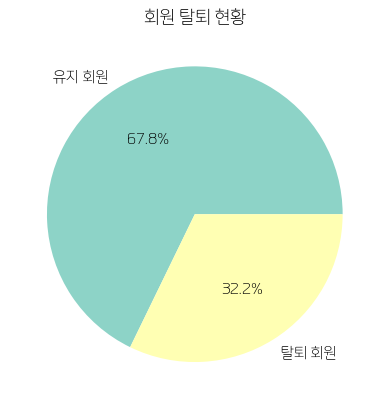

In [446]:
plt.pie(temp['count'],labels = ['유지 회원','탈퇴 회원'],autopct='%1.1f%%',colors=sns.color_palette('Set3'))
plt.title("회원 탈퇴 현황")

### 1. 클래스

In [447]:
temp = master_df.groupby('클래스ID').count()['회원ID'].reset_index()
temp = pd.merge(temp,class_df,how='left',on='클래스ID')
temp

,클래스ID,회원ID,클래스분류,가격
0,C01,2045,0_종일,10500
1,C02,1019,1_주간,7500
2,C03,1128,2_야간,6000


Text(0.5, 1.0, '클래스별 회원 수 비중')

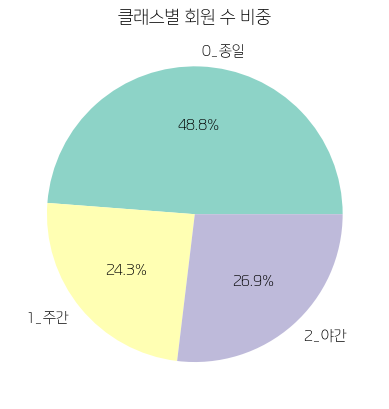

In [448]:
plt.pie(temp['회원ID'],labels = temp['클래스분류'],autopct='%1.1f%%',colors=sns.color_palette('Set3'))
plt.title("클래스별 회원 수 비중")

In [449]:
temp = master_df.groupby(['클래스ID', '탈퇴여부'])['회원ID'].count().reset_index()
temp = pd.merge(temp,class_df,how='left',on='클래스ID')
temp

,클래스ID,탈퇴여부,회원ID,클래스분류,가격
0,C01,0,1381,0_종일,10500
1,C01,1,664,0_종일,10500
2,C02,0,675,1_주간,7500
3,C02,1,344,1_주간,7500
4,C03,0,786,2_야간,6000
5,C03,1,342,2_야간,6000


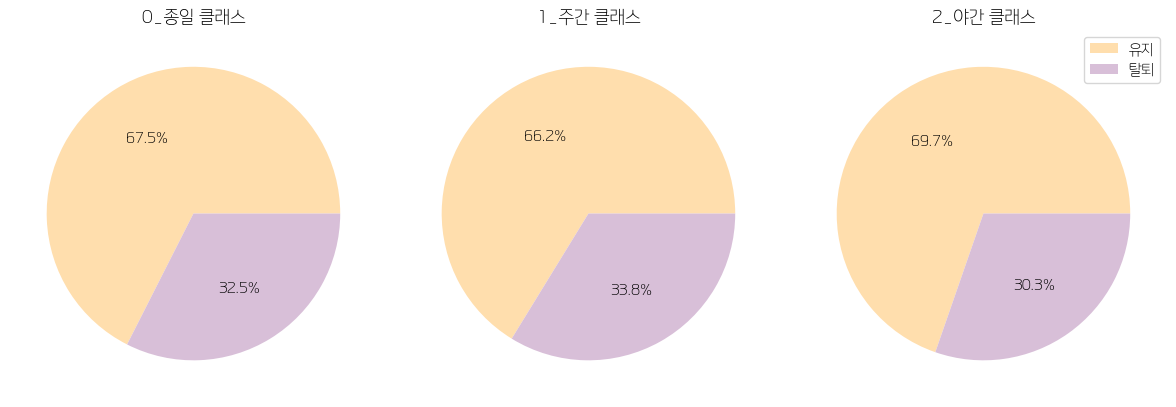

In [450]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].pie(temp[:2]['회원ID'],autopct='%1.1f%%',colors=['navajowhite','thistle'])
ax[0].set_title(f"{temp['클래스분류'].unique()[0]} 클래스")
ax[1].pie(temp[2:4]['회원ID'],autopct='%1.1f%%',colors=['navajowhite','thistle'])
ax[1].set_title(f"{temp['클래스분류'].unique()[1]} 클래스")
ax[2].pie(temp[4:]['회원ID'],autopct='%1.1f%%',colors=['navajowhite','thistle'])
ax[2].set_title(f"{temp['클래스분류'].unique()[2]} 클래스")

plt.legend(labels=['유지','탈퇴'])
plt.tight_layout()
plt.show()

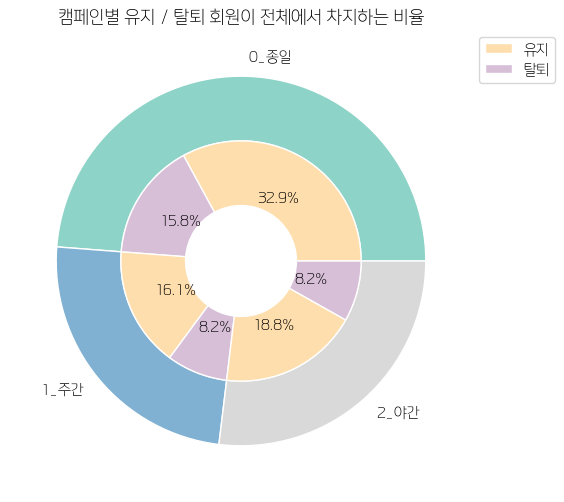

In [451]:
fig, ax = plt.subplots(figsize=(6,6))

size = 0.35
vals = np.array([temp['회원ID'][:2], temp['회원ID'][2:4], temp['회원ID'][4:]])

cmap = plt.colormaps["Set3"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = ['navajowhite','thistle']

outer_pie = ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=temp['클래스분류'].unique())

inner_pie = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),autopct='%1.1f%%')

ax.set(aspect="equal", title='캠페인별 유지 / 탈퇴 회원이 전체에서 차지하는 비율')
ax.legend(inner_pie[0], ['유지', '탈퇴'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### 2. 캠페인 유형
- 일반 캠페인 가입자가 가장 많다
- 일반 캠페인 가입자의 이탈률은 23.2%, 그 외 캠페인은 약 55% 퍼센트
- 전체 회원 수 대비 이탈 회원이 가장 적은 곳은 일반 캠페인
- 입회비 무료와 입회비반액할인으로 등록한 회원의 경우 이탈률이 높고 가입 수도 적다. 모객 이벤트로 제대로 기능할 지 모르나 해당 캠페인 이용자들에 대해 이탈 방지 전략이 필요

In [452]:
temp = master_df.groupby(['혜택'])['캠페인ID'].count().reset_index()
temp

,혜택,캠페인ID
0,0_입회비반액할인,650
1,1_입회비무료,492
2,2_일반,3050


Text(0.5, 1.0, '캠페인별 등록 회원 비율')

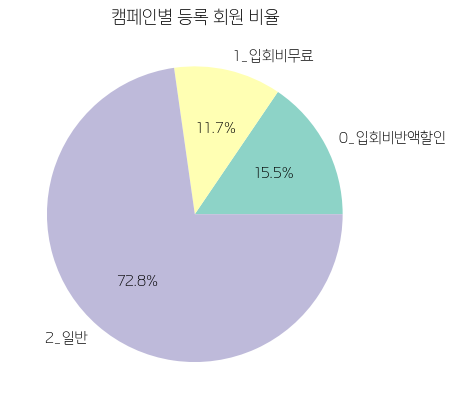

In [453]:
plt.pie(temp['캠페인ID'],labels = temp['혜택'],autopct='%1.1f%%',colors=sns.color_palette('Set3'))
plt.title("캠페인별 등록 회원 비율")

In [454]:
temp = master_df.groupby(['캠페인ID','탈퇴여부']).count()['회원ID'].reset_index()
temp = pd.merge(temp,campaign_df,how='left',on='캠페인ID')
temp

,캠페인ID,탈퇴여부,회원ID,혜택
0,CA1,0,2341,2_일반
1,CA1,1,709,2_일반
2,CA2,0,282,0_입회비반액할인
3,CA2,1,368,0_입회비반액할인
4,CA3,0,219,1_입회비무료
5,CA3,1,273,1_입회비무료


In [455]:
type(temp['탈퇴여부'][0])

numpy.int64

In [456]:
target_camp = temp['캠페인ID'].unique()[0]
target_camp

target_camp_retention = temp[(temp['탈퇴여부'] == 0) & (temp['캠페인ID'] == target_camp)]['회원ID']
target_camp_retention

0    2341
Name: 회원ID, dtype: int64

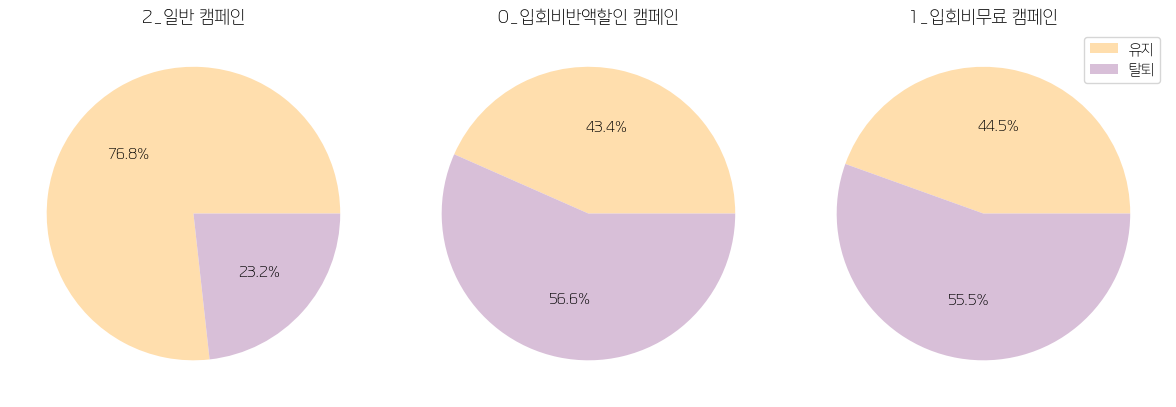

In [457]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].pie(temp[:2]['회원ID'],autopct='%1.1f%%',colors=['navajowhite','thistle'])
ax[0].set_title(f"{master_df['혜택'].unique()[0]} 캠페인")
ax[1].pie(temp[2:4]['회원ID'],autopct='%1.1f%%',colors=['navajowhite','thistle'])
ax[1].set_title(f"{master_df['혜택'].unique()[1]} 캠페인")
ax[2].pie(temp[4:]['회원ID'],autopct='%1.1f%%',colors=['navajowhite','thistle'])
ax[2].set_title(f"{master_df['혜택'].unique()[2]} 캠페인")

plt.legend(labels=['유지','탈퇴'])
plt.tight_layout()
plt.show()

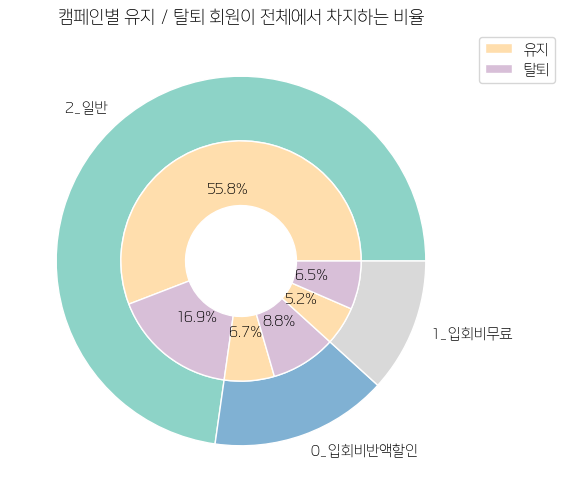

In [458]:
fig, ax = plt.subplots(figsize=(6,6))

size = 0.35
vals = np.array([temp['회원ID'][:2], temp['회원ID'][2:4], temp['회원ID'][4:]])

cmap = plt.colormaps["Set3"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = ['navajowhite','thistle']

outer_pie = ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=temp['혜택'].unique())

inner_pie = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),autopct='%1.1f%%')

ax.set(aspect="equal", title='캠페인별 유지 / 탈퇴 회원이 전체에서 차지하는 비율')
ax.legend(inner_pie[0], ['유지', '탈퇴'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### 3. 성별
- 여성 47.3%, 남성 52.7%로 고른 분포
- 성별 이탈률 또한 여성 15.1%, 남성 17.2%로 유사

In [459]:
temp = master_df.groupby('성별').count()['회원ID'].reset_index()
temp

,성별,회원ID
0,F,1983
1,M,2209


Text(0.5, 1.0, '회원 성비')

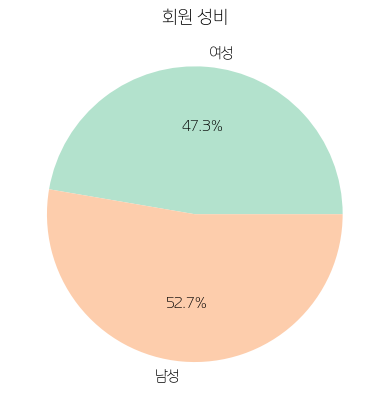

In [460]:
plt.pie(temp['회원ID'],labels = ['여성','남성'],autopct='%1.1f%%',colors=sns.color_palette('Pastel2'))
plt.title("회원 성비")

In [461]:
temp = master_df.groupby(['성별', '탈퇴여부'])['회원ID'].count().reset_index()
temp

,성별,탈퇴여부,회원ID
0,F,0,1352
1,F,1,631
2,M,0,1490
3,M,1,719


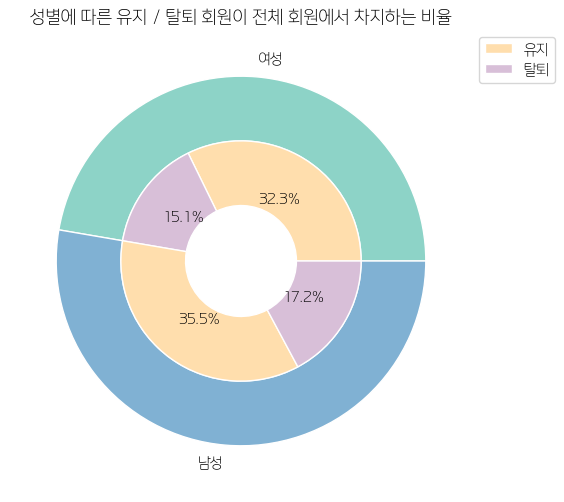

In [462]:
fig, ax = plt.subplots(figsize=(6,6))

size = 0.35
vals = np.array([temp['회원ID'][:2], temp['회원ID'][2:4]])

cmap = plt.colormaps["Set3"]
outer_colors = cmap(np.arange(2)*4)
inner_colors = ['navajowhite','thistle']

outer_pie = ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=['여성','남성'])

inner_pie = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),autopct='%1.1f%%')

ax.set(aspect="equal", title='성별에 따른 유지 / 탈퇴 회원이 전체 회원에서 차지하는 비율')
ax.legend(inner_pie[0], ['유지', '탈퇴'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### 4. 등록 및 탈퇴 시기

In [463]:
customer_start_df = pd.DataFrame(data=customer_df.groupby('등록연월')['회원ID'].count()).reset_index()
customer_start_df = customer_start_df.rename(columns={'회원ID':'등록 수'})
customer_start_df

,등록연월,등록 수
0,2015-05,62
1,2015-06,69
2,2015-07,53
3,2015-08,53
4,2015-09,71
5,2015-10,54
6,2015-11,63
7,2015-12,67
8,2016-01,56
9,2016-02,48


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, '2018-04'),
  Text(1, 0, '2018-05'),
  Text(2, 0, '2018-06'),
  Text(3, 0, '2018-07'),
  Text(4, 0, '2018-08'),
  Text(5, 0, '2018-09'),
  Text(6, 0, '2018-10'),
  Text(7, 0, '2018-11'),
  Text(8, 0, '2018-12'),
  Text(9, 0, '2019-01'),
  Text(10, 0, '2019-02')])

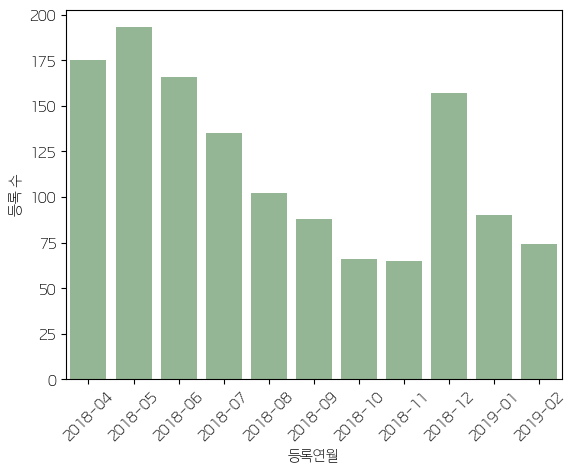

In [464]:
sns.barplot(x='등록연월',y='등록 수',data=customer_start_df[35:-1],color='darkseagreen')
plt.xticks(rotation=45)

In [465]:
customer_end_df = pd.DataFrame(data=customer_df.groupby('탈퇴연월')['회원ID'].count()).reset_index()
customer_end_df = customer_end_df.rename(columns={'회원ID':'탈퇴 수'})
customer_end_df

,탈퇴연월,탈퇴 수
0,2018-04,121
1,2018-05,125
2,2018-06,106
3,2018-07,102
4,2018-08,113
5,2018-09,104
6,2018-10,90
7,2018-11,89
8,2018-12,111
9,2019-01,129


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '2018-04'),
  Text(1, 0, '2018-05'),
  Text(2, 0, '2018-06'),
  Text(3, 0, '2018-07'),
  Text(4, 0, '2018-08'),
  Text(5, 0, '2018-09'),
  Text(6, 0, '2018-10'),
  Text(7, 0, '2018-11'),
  Text(8, 0, '2018-12'),
  Text(9, 0, '2019-01'),
  Text(10, 0, '2019-02'),
  Text(11, 0, '2019-03')])

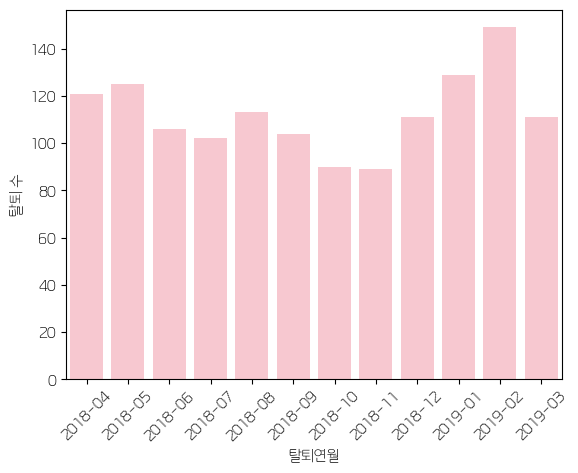

In [466]:
sns.barplot(x='탈퇴연월',y='탈퇴 수',data=customer_end_df[:-1],color='pink')
plt.xticks(rotation=45)

In [467]:
customer_retention_df = pd.merge(customer_start_df,customer_end_df,how='outer',left_on='등록연월',right_on='탈퇴연월')
customer_retention_df

,등록연월,등록 수,탈퇴연월,탈퇴 수
0,2015-05,62.0,NaN,NaN
1,2015-06,69.0,NaN,NaN
2,2015-07,53.0,NaN,NaN
3,2015-08,53.0,NaN,NaN
4,2015-09,71.0,NaN,NaN
5,2015-10,54.0,NaN,NaN
6,2015-11,63.0,NaN,NaN
7,2015-12,67.0,NaN,NaN
8,2016-01,56.0,NaN,NaN
9,2016-02,48.0,NaN,NaN


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '2018-04'),
  Text(1, 0, '2018-05'),
  Text(2, 0, '2018-06'),
  Text(3, 0, '2018-07'),
  Text(4, 0, '2018-08'),
  Text(5, 0, '2018-09'),
  Text(6, 0, '2018-10'),
  Text(7, 0, '2018-11'),
  Text(8, 0, '2018-12'),
  Text(9, 0, '2019-01'),
  Text(10, 0, '2019-02'),
  Text(11, 0, '2019-03')])

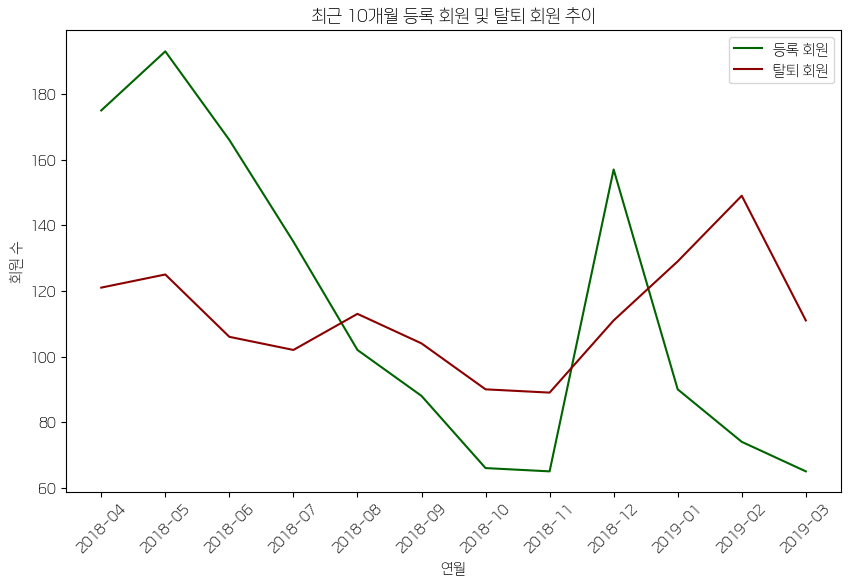

In [468]:
plt.figure(figsize=(10, 6)) 
plt.plot(customer_retention_df['등록연월'][35:-1], customer_retention_df['등록 수'][35:-1], label = '등록 회원', color='darkgreen')
plt.plot(customer_retention_df['등록연월'][35:-1], customer_retention_df['탈퇴 수'][35:-1], label = '탈퇴 회원', color='darkred')
plt.xlabel("연월")
plt.ylabel("회원 수")
plt.legend()
plt.title("최근 10개월 등록 회원 및 탈퇴 회원 추이")
plt.xticks(rotation=45)

## EDA 03: 회원들의 이용 특성 파악
- 이용권 유지 기간
- 평균 월 이용 횟수
- 정기적 이용 여부

### 1.이용권 유지 기간

In [469]:
master_df['회원등록일'] = pd.to_datetime(master_df['회원등록일'])
master_df['회원탈퇴일'] = pd.to_datetime(master_df['회원탈퇴일'])
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   회원ID    4192 non-null   object        
 1   회원명     4192 non-null   object        
 2   클래스ID   4192 non-null   object        
 3   성별      4192 non-null   object        
 4   회원등록일   4192 non-null   datetime64[ns]
 5   회원탈퇴일   4192 non-null   datetime64[ns]
 6   캠페인ID   4192 non-null   object        
 7   탈퇴여부    4192 non-null   int64         
 8   등록연월    4192 non-null   object        
 9   등록일     4192 non-null   object        
 10  탈퇴연월    4192 non-null   object        
 11  탈퇴일     4192 non-null   object        
 12  혜택      4192 non-null   object        
 13  클래스분류   4192 non-null   object        
 14  가격      4192 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(11)
memory usage: 491.4+ KB


In [470]:
master_df['등록유지기간'] = master_df['회원탈퇴일'] - master_df['회원등록일']
master_df['등록유지기간'].mean()

Timedelta('599 days 14:23:35.267175576')

In [471]:
print(master_df['등록유지기간'].dt.days.max())
print(master_df['등록유지기간'].dt.days.min())

1460
44


In [472]:
master_df['등록유지기간'] = master_df['등록유지기간'].dt.days
quit_customers = master_df[master_df['탈퇴여부']==1]
quit_customers

,회원ID,회원명,클래스ID,성별,회원등록일,회원탈퇴일,캠페인ID,탈퇴여부,등록연월,등록일,탈퇴연월,탈퇴일,혜택,클래스분류,가격,등록유지기간
708,TS511179,XXXXXX,C01,F,2016-05-01,2018-04-30,CA1,1,2016-05,01,2018-04,30,2_일반,0_종일,10500,729
729,TS443736,XXXX,C02,M,2016-05-01,2018-04-30,CA1,1,2016-05,01,2018-04,30,2_일반,1_주간,7500,729
730,HD542886,XX,C01,M,2016-05-01,2018-04-30,CA1,1,2016-05,01,2018-04,30,2_일반,0_종일,10500,729
770,HD597545,XXXXX,C03,F,2016-06-01,2018-05-31,CA1,1,2016-06,01,2018-05,31,2_일반,2_야간,6000,729
785,HI749296,XXXXX,C01,M,2016-06-01,2018-05-31,CA1,1,2016-06,01,2018-05,31,2_일반,0_종일,10500,729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,OA143589,XXXXX,C03,F,2019-01-15,2019-02-28,CA1,1,2019-01,15,2019-02,28,2_일반,2_야간,6000,44
4050,GD367382,XXXX,C01,M,2019-01-15,2019-03-31,CA1,1,2019-01,15,2019-03,31,2_일반,0_종일,10500,75
4068,OA034442,XXXXX,C02,M,2019-02-05,2019-03-31,CA1,1,2019-02,05,2019-03,31,2_일반,1_주간,7500,54
4086,PL508278,XXXXX,C03,M,2019-02-09,2019-03-31,CA1,1,2019-02,09,2019-03,31,2_일반,2_야간,6000,50


#### 탈퇴 회원들의 유지 기간

Text(0.5, 1.0, '스포츠센터 탈퇴 회원 등록 유지 기간')

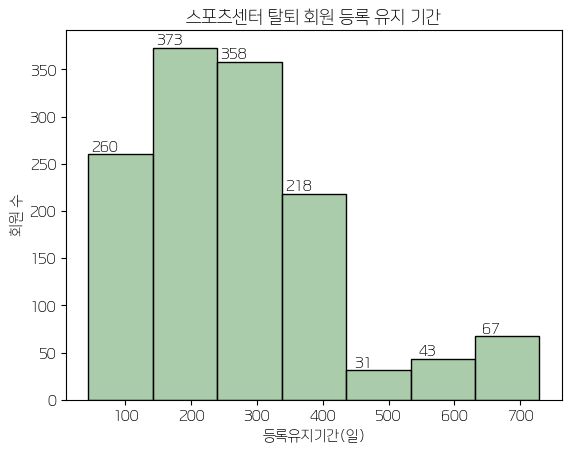

In [473]:
quit_customers = master_df[master_df['탈퇴여부']==1]
hist = sns.histplot(data=quit_customers, x="등록유지기간", color='darkseagreen', bins=7, stat='count', ax=None)
bin_counts, bin_edges = np.histogram(quit_customers["등록유지기간"], bins=7)

for i, count in enumerate(bin_counts):
    plt.text(bin_edges[i]+25, count, str(int(count)), ha='center', va='bottom')

hist.set_xlabel("등록유지기간(일)")
hist.set_ylabel("회원 수")
plt.title("스포츠센터 탈퇴 회원 등록 유지 기간")

#### 등록유지기간 추이 (일자별)

(array([857., 694., 475., 368., 311., 331., 323., 237., 288., 308.]),
 array([  44. ,  185.6,  327.2,  468.8,  610.4,  752. ,  893.6, 1035.2,
        1176.8, 1318.4, 1460. ]),
 <BarContainer object of 10 artists>)

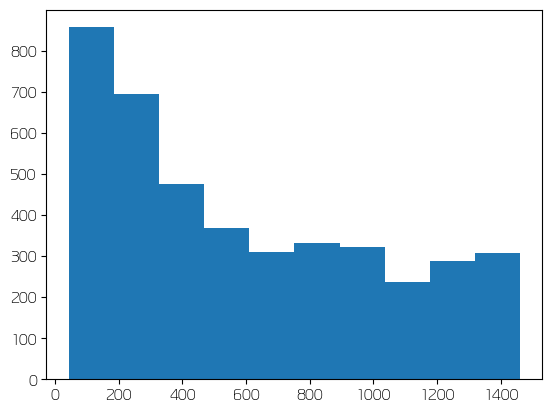

In [513]:
import matplotlib.pyplot as plt
plt.hist(master_df['등록유지기간'])

# 일자로 보면 400일 까지 줄어들면서 이후 안정되는 모습

#### 등록유지기간 월 기준 계산 후 다시 시각화

In [475]:
delta_months = [(end_date.year - start_date.year) * 12 + end_date.month - start_date.month for end_date,start_date in zip(master_df['회원탈퇴일'],master_df['회원등록일'])]
master_df['등록유지기간(월)'] = delta_months
master_df

,회원ID,회원명,클래스ID,성별,회원등록일,회원탈퇴일,캠페인ID,탈퇴여부,등록연월,등록일,탈퇴연월,탈퇴일,혜택,클래스분류,가격,등록유지기간,등록유지기간(월)
0,OA832399,XXXX,C01,F,2015-05-01,2019-04-30,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47
1,PL270116,XXXXX,C01,M,2015-05-01,2019-04-30,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47
2,OA974876,XXXXX,C01,M,2015-05-01,2019-04-30,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47
3,HD024127,XXXXX,C01,F,2015-05-01,2019-04-30,CA1,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47
4,HD661448,XXXXX,C03,F,2015-05-01,2019-04-30,CA1,0,2015-05,01,2019-04,30,2_일반,2_야간,6000,1460,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,2019-04-30,CA1,0,2019-03,14,2019-04,30,2_일반,0_종일,10500,47,1
4188,HD246549,XXXXX,C01,F,2019-03-14,2019-04-30,CA1,0,2019-03,14,2019-04,30,2_일반,0_종일,10500,47,1
4189,GD037007,XXXXX,C03,M,2019-03-14,2019-04-30,CA1,0,2019-03,14,2019-04,30,2_일반,2_야간,6000,47,1
4190,OA953150,XXXXX,C01,M,2019-03-14,2019-04-30,CA1,0,2019-03,14,2019-04,30,2_일반,0_종일,10500,47,1


(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

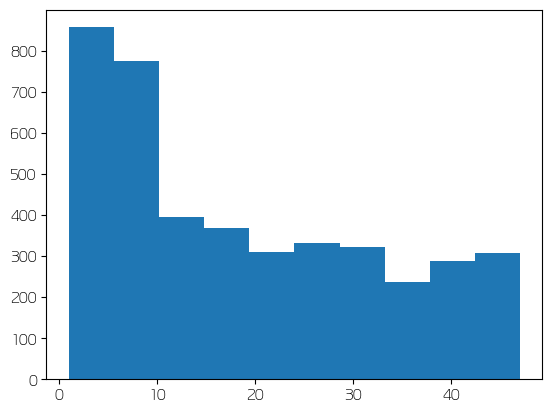

In [476]:
plt.hist(master_df['등록유지기간(월)'])
# 등록 후 10개월이 지나면 급격히 줄어든다

### 2. 이용이력 특성
* 1. 전일 이용 횟수의 변화
* 2. 회원이 스포츠센터에 정기적으로 오고 있는지

In [514]:
uselog_df.head()

,로그ID,회원ID,이용일자,이용연월,이용요일
0,L00000049012330,AS009373,2018-04-01,201804,6
1,L00000049012331,AS015315,2018-04-01,201804,6
2,L00000049012332,AS040841,2018-04-01,201804,6
3,L00000049012333,AS046594,2018-04-01,201804,6
4,L00000049012334,AS073285,2018-04-01,201804,6


* 월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값

In [516]:
uselog_df.groupby('이용연월').count()['이용일자'].describe()

count       12.000000
mean     16452.333333
std        393.031420
min      15697.000000
25%      16311.000000
50%      16421.500000
75%      16733.750000
max      16994.000000
Name: 이용일자, dtype: float64

In [517]:
(uselog_df.groupby(['이용연월','회원ID']).count()['이용일자']).groupby('회원ID').mean()

회원ID
AS002855    4.500000
AS008805    4.000000
AS009013    2.000000
AS009373    5.083333
AS015233    7.545455
              ...   
TS995853    9.500000
TS998593    8.142857
TS999079    4.916667
TS999231    4.666667
TS999855    4.583333
Name: 이용일자, Length: 4192, dtype: float64

* 고객마다 월 이용 횟수 집계

In [518]:
uselog_df_monthly = uselog_df.pivot_table(index=['회원ID','이용연월'],aggfunc='size',fill_value=0)
uselog_df_monthly

회원ID      이용연월  
AS002855  201804    4
          201805    5
          201806    5
          201807    5
          201808    3
                   ..
TS999855  201811    4
          201812    5
          201901    7
          201902    4
          201903    4
Length: 36842, dtype: int64

In [519]:
uselog_df_monthly.describe()

count    36842.000000
mean         5.358775
std          2.180240
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         14.000000
dtype: float64

##### 교수님 버전  

In [520]:
# 고객별 월별 이용 횟수 집계

uselog_months = uselog_df.groupby(['이용연월','회원ID'],as_index=False).count()
uselog_months.rename(columns={'로그ID':'count'},inplace=True)
uselog_months.head()

,이용연월,회원ID,count,이용일자,이용요일
0,201804,AS002855,4,4,4
1,201804,AS009013,2,2,2
2,201804,AS009373,3,3,3
3,201804,AS015315,6,6,6
4,201804,AS015739,7,7,7


### 3. 정기적 이용 여부
- 월별 정기적 이용 여부: 회원마다 월/요일별 집계 최댓값이 4 이상인 요일이 있으면 플래그 1로 처리
- 회원별 정기적 이용 점수 : 회원별 월별 정기적 이용 여부를 모두 더해 높을 수록 정기적으로 이용하는 경향

#### 고객마다 월/요일별 집계

In [521]:
uselog_df.head()

,로그ID,회원ID,이용일자,이용연월,이용요일
0,L00000049012330,AS009373,2018-04-01,201804,6
1,L00000049012331,AS015315,2018-04-01,201804,6
2,L00000049012332,AS040841,2018-04-01,201804,6
3,L00000049012333,AS046594,2018-04-01,201804,6
4,L00000049012334,AS073285,2018-04-01,201804,6


In [522]:
use_log_weekday = []
for day in uselog_df['이용일자']:
    use_log_weekday.append(day.weekday())

uselog_df['이용요일'] = use_log_weekday
uselog_df.head()

,로그ID,회원ID,이용일자,이용연월,이용요일
0,L00000049012330,AS009373,2018-04-01,201804,6
1,L00000049012331,AS015315,2018-04-01,201804,6
2,L00000049012332,AS040841,2018-04-01,201804,6
3,L00000049012333,AS046594,2018-04-01,201804,6
4,L00000049012334,AS073285,2018-04-01,201804,6


#### 회원별 - 이용요일별 이용 수

In [523]:
uselog_df_weekday = uselog_df.groupby(['회원ID','이용연월','이용요일'], as_index=False).count()[['회원ID','이용연월','이용요일','로그ID']]
uselog_df_weekday.rename(columns={'로그ID':'count'},inplace=True)             # log_id를 count로 rename
uselog_df_weekday.head()

,회원ID,이용연월,이용요일,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [488]:
uselog_df_weekday.head(20)

,회원ID,이용연월,이용요일,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1
5,AS002855,201807,5,4
6,AS002855,201808,0,1
7,AS002855,201808,3,1
8,AS002855,201808,6,1
9,AS002855,201809,1,1


In [525]:
uselog_routine_count = uselog_df_weekday.groupby(['회원ID','이용연월']).max()
uselog_routine_count['정기이용'] = 0
uselog_routine_count['정기이용'] = [y + 1 if x >= 4 else y for x, y in zip(uselog_routine_count['count'],uselog_routine_count['정기이용'])]
uselog_routine_count

이용요일  count  정기이용
회원ID     이용연월                     
AS002855 201804     5      4     1
         201805     5      4     1
         201806     5      5     1
         201807     5      4     1
         201808     6      1     0
...               ...    ...   ...
TS999855 201811     5      4     1
         201812     5      5     1
         201901     6      4     1
         201902     5      4     1
         201903     5      4     1

[36842 rows x 3 columns]

In [526]:
routinary_score = uselog_routine_count.groupby('회원ID').sum()['정기이용']
routinary_score = pd.DataFrame(routinary_score)
routinary_score.reset_index(inplace=True)
master_df = pd.merge(master_df, routinary_score, how='left',on='회원ID')
master_df.head()

,회원ID,회원명,클래스ID,성별,회원등록일,회원탈퇴일,캠페인ID,탈퇴여부,등록연월,등록일,탈퇴연월,탈퇴일,혜택,클래스분류,가격,등록유지기간,등록유지기간(월),정기이용_x,정기이용_y
0,OA832399,XXXX,0,0,2015-05-01,2019-04-30,0,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47,10,10
1,PL270116,XXXXX,0,1,2015-05-01,2019-04-30,0,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47,9,9
2,OA974876,XXXXX,0,1,2015-05-01,2019-04-30,0,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47,9,9
3,HD024127,XXXXX,0,0,2015-05-01,2019-04-30,0,0,2015-05,01,2019-04,30,2_일반,0_종일,10500,1460,47,9,9
4,HD661448,XXXXX,2,0,2015-05-01,2019-04-30,0,0,2015-05,01,2019-04,30,2_일반,2_야간,6000,1460,47,7,7


In [493]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   회원ID       4192 non-null   object        
 1   회원명        4192 non-null   object        
 2   클래스ID      4192 non-null   object        
 3   성별         4192 non-null   object        
 4   회원등록일      4192 non-null   datetime64[ns]
 5   회원탈퇴일      4192 non-null   datetime64[ns]
 6   캠페인ID      4192 non-null   object        
 7   탈퇴여부       4192 non-null   int64         
 8   등록연월       4192 non-null   object        
 9   등록일        4192 non-null   object        
 10  탈퇴연월       4192 non-null   object        
 11  탈퇴일        4192 non-null   object        
 12  혜택         4192 non-null   object        
 13  클래스분류      4192 non-null   object        
 14  가격         4192 non-null   int64         
 15  등록유지기간     4192 non-null   int64         
 16  등록유지기간(월)  4192 non-null   int64         


In [527]:
master_df.to_csv(os.path.join(file_dir,'master.csv'))

## EDA 04: 상관계수

In [494]:
customers_quit = master_df[master_df['탈퇴여부']==1]
customers_quit.describe()

,회원등록일,회원탈퇴일,탈퇴여부,가격,등록유지기간,등록유지기간(월),정기이용
count,1350,1350,1350.0,1350.000000,1350.000000,1350.000000,1350.000000
mean,2018-01-20 10:45:20,2018-10-17 16:23:28,1.0,8595.555556,270.234815,8.026667,0.794074
min,2016-05-01 00:00:00,2018-04-30 00:00:00,1.0,6000.000000,44.000000,1.000000,0.000000
25%,2017-10-01 00:00:00,2018-06-30 00:00:00,1.0,6000.000000,150.000000,4.000000,0.000000
50%,2018-03-01 00:00:00,2018-10-31 00:00:00,1.0,7500.000000,242.000000,7.000000,0.000000
75%,2018-06-03 00:00:00,2019-01-31 00:00:00,1.0,10500.000000,364.000000,11.000000,1.000000
max,2019-02-11 00:00:00,2019-03-31 00:00:00,1.0,10500.000000,729.000000,23.000000,7.000000
std,NaN,NaN,0.0,1949.163652,155.096341,5.033692,1.098807


In [495]:
customers_stay = master_df[master_df['탈퇴여부']==0]
customers_stay.describe()

,회원등록일,회원탈퇴일,탈퇴여부,가격,등록유지기간,등록유지기간(월),정기이용
count,2842,2842,2842.0,2842.000000,2842.000000,2842.000000,2842.000000
mean,2017-04-03 22:42:28.627726848,2019-04-30 00:00:00,0.0,8542.927516,756.053835,23.970443,7.056298
min,2015-05-01 00:00:00,2019-04-30 00:00:00,0.0,6000.000000,46.000000,1.000000,0.000000
25%,2016-05-01 00:00:00,2019-04-30 00:00:00,0.0,6000.000000,390.000000,12.000000,6.000000
50%,2017-04-01 00:00:00,2019-04-30 00:00:00,0.0,7500.000000,759.000000,24.000000,8.000000
75%,2018-04-05 00:00:00,2019-04-30 00:00:00,0.0,10500.000000,1094.000000,35.000000,9.000000
max,2019-03-15 00:00:00,2019-04-30 00:00:00,0.0,10500.000000,1460.000000,47.000000,12.000000
std,NaN,NaN,0.0,1977.189779,420.864717,13.746761,2.720397


#### 상관계수 파악

In [508]:
encoded_df = master_df.select_dtypes('int')
encoded_df

,클래스ID,성별,캠페인ID,탈퇴여부,가격,등록유지기간,등록유지기간(월),정기이용
0,0,0,0,0,10500,1460,47,10
1,0,1,0,0,10500,1460,47,9
2,0,1,0,0,10500,1460,47,9
3,0,0,0,0,10500,1460,47,9
4,2,0,0,0,6000,1460,47,7
...,...,...,...,...,...,...,...,...
4187,0,1,0,0,10500,47,1,0
4188,0,0,0,0,10500,47,1,0
4189,2,1,0,0,6000,47,1,0
4190,0,1,0,0,10500,47,1,0


In [498]:
object_cols = master_df.select_dtypes('object').columns
object_cols

Index(['회원ID', '회원명', '클래스ID', '성별', '캠페인ID', '등록연월', '등록일', '탈퇴연월', '탈퇴일',
       '혜택', '클래스분류'],
      dtype='object')

In [500]:
from sklearn.preprocessing import LabelEncoder

target_cols = object_cols[2:5]
for target_col in target_cols:
    labels = master_df[target_col].unique()
    for label in labels:
        le = LabelEncoder()
        le = le.fit(master_df[target_col])
        encoded_df[target_col] = le.transform(master_df[target_col])

In [509]:
encoded_df

,클래스ID,성별,캠페인ID,탈퇴여부,가격,등록유지기간,등록유지기간(월),정기이용
0,0,0,0,0,10500,1460,47,10
1,0,1,0,0,10500,1460,47,9
2,0,1,0,0,10500,1460,47,9
3,0,0,0,0,10500,1460,47,9
4,2,0,0,0,6000,1460,47,7
...,...,...,...,...,...,...,...,...
4187,0,1,0,0,10500,47,1,0
4188,0,0,0,0,10500,47,1,0
4189,2,1,0,0,6000,47,1,0
4190,0,1,0,0,10500,47,1,0


In [510]:
encoded_df.corr()

,클래스ID,성별,캠페인ID,탈퇴여부,가격,등록유지기간,등록유지기간(월),정기이용
클래스ID,1.000000,0.035304,-0.019600,-0.016180,-0.986840,-0.011861,-0.011754,0.000175
성별,0.035304,1.000000,-0.010458,0.007781,0.030285,-0.003988,-0.004156,0.005693
캠페인ID,-0.019600,-0.010458,1.000000,0.287985,0.018103,-0.384039,-0.383654,-0.253929
탈퇴여부,-0.016180,0.007781,0.287985,1.000000,0.012496,-0.536075,-0.538033,-0.782980
가격,-0.986840,0.030285,0.018103,0.012496,1.000000,0.013343,0.013252,0.001981
등록유지기간,-0.011861,-0.003988,-0.384039,-0.536075,0.013343,1.000000,0.999968,0.613769
등록유지기간(월),-0.011754,-0.004156,-0.383654,-0.538033,0.013252,0.999968,1.000000,0.613826
정기이용,0.000175,0.005693,-0.253929,-0.782980,0.001981,0.613769,0.613826,1.000000
